# Reproduce Figure 5 and S5

This notebook contains code to reproduce analyses in Figure 5 and S5 from Yang\*, Jones\* et al, _bioRxiv_ 2021.

In [1]:
import os
import sys

from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

sys.path.append("scripts/")
import tree_utilities

## Evolutionary Coupling

In [2]:
adata = sc.read_h5ad('/data/yosef2/users/mattjones/projects/kptc/RNA/NT/adata_processed.filtered.subcluster.nt.h5ad')

### Individual tumors - Figure 5A-D

In [3]:
tumor = '3435_NT_T1'
graph = tree_utilities.prepare_tumor_tree(tumor, adata,
                                          tree_dir = "/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/trees/",
                                          FILTER_PROP=0.025, column='leiden_sub')

for u, v in graph.edges():
    _length = graph[u][v]["length"]
    if _length > 0:
        _length = 1
    graph[u][v]["length"] = _length

phylogenetic_distance_matrix, leaf_pairs, edit_distance_matrix, tree_diameter, n_targets = tree_utilities.compute_pairwise_dist_nx(graph)

_leaves = [n for n in graph if graph.out_degree(n) == 0]
np.fill_diagonal(phylogenetic_distance_matrix.values, 0)
leaf_states = adata.obs.loc[_leaves, 'leiden_sub']

observed_inter_cluster_df = tree_utilities.get_inter_cluster_df(leaf_states, phylogenetic_distance_matrix)

Creating pairs to compare:   0%|          | 0/1069 [00:00<?, ?it/s]

Finding LCAs for all pairs...
Computing pairwise distances...


In [4]:
B = 1000
background = defaultdict(list)
for _ in tqdm(range(B)):
    permuted_assignments = leaf_states.copy()
    permuted_assignments.index = np.random.permutation(leaf_states.index.values)
    bg_df = tree_utilities.get_inter_cluster_df(permuted_assignments, phylogenetic_distance_matrix)
    
    for s1 in bg_df.index:
        for s2 in bg_df.index:
            background[(s1, s2)].append(bg_df.loc[s1, s2])
            
null_means = observed_inter_cluster_df.copy()
null_sds = observed_inter_cluster_df.copy()

for s1 in null_means.index:
    for s2 in null_means.columns:
        null_means.loc[s1, s2] = np.mean(background[(s1, s2)])
        null_sds.loc[s1, s2] = np.std(background[(s1, s2)])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
z_df = observed_inter_cluster_df.copy()
for ind in z_df.index:
    for col in z_df.columns:
        z_df.loc[ind, col] = (z_df.loc[ind, col] - null_means.loc[ind, col]) / null_sds.loc[ind, col]
z_df.fillna(0, inplace=True)

mu = np.mean(z_df.values.ravel())
sigma = np.std(z_df.values.ravel())

zz_df = z_df.apply(lambda x: (x - mu) / sigma, axis=1)

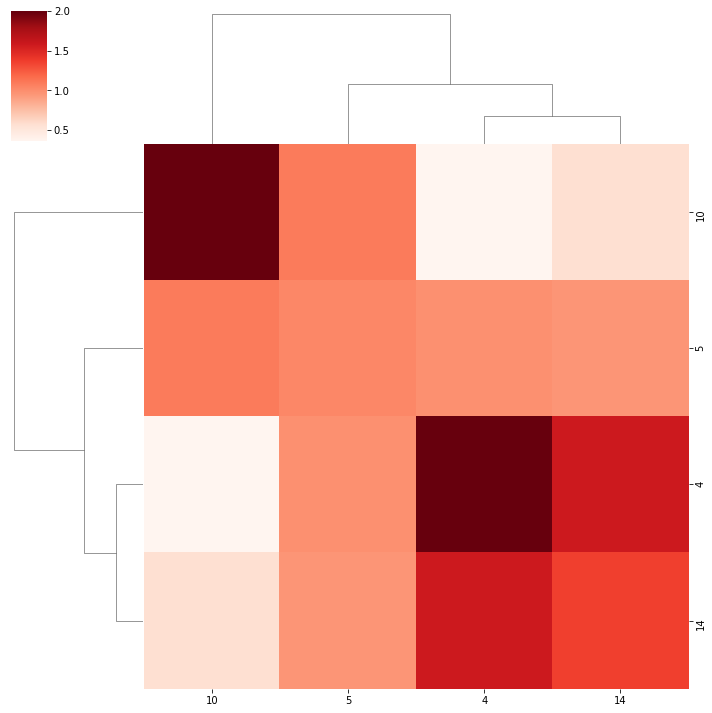

In [6]:
sns.clustermap(np.exp(-zz_df / zz_df.abs().max().max()), cmap='Reds', method='ward', vmax=2.0)

### Plot couplings on an UMAP - Figure S5L

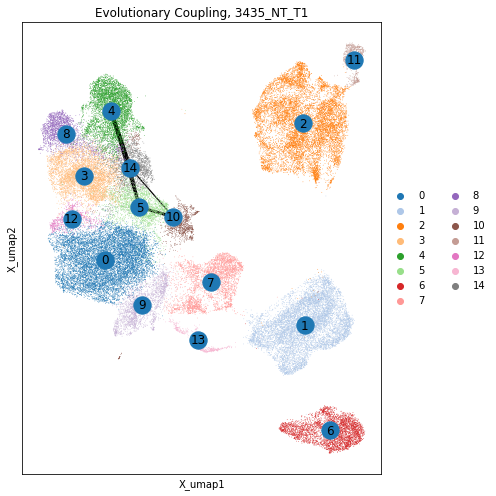

In [8]:
uniq_labels = adata.obs['leiden_sub'].astype(int).unique()
_normalized_cluster_df = pd.DataFrame(np.zeros((len(uniq_labels), len(uniq_labels))), index=uniq_labels, columns = uniq_labels)
for i in zz_df.index:
    for j in zz_df.columns:
        _normalized_cluster_df.loc[i, j] = (zz_df.max().max() - zz_df).loc[i, j]

tree_utilities.plot_graph_on_umap(adata, _normalized_cluster_df, weight=1,
                                  cluster_column = 'leiden_sub', title=f'Evolutionary Coupling, {tumor}')



## Compare evolutionary couplings from different methods - Figure S5A-E

Phylogenetic distance matrices were computed using `./scripts/compute_dissimilarity_matrices.py`

In [13]:
tumor = '3435_NT_T1'
K = 10

graph = tree_utilities.prepare_tumor_tree(tumor, adata,
                                          tree_dir = "/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/trees",
                                          FILTER_PROP=0.025,
                                          column='leiden_sub')

phylogenetic_distance_matrix = pd.read_csv(f'./data/{tumor}_phylogenetic_distance_matrix.tsv', sep='\t', index_col = 0)
edit_distance_matrix = pd.read_csv(f'./data/{tumor}_edit_distance_matrix.tsv', sep='\t', index_col = 0)

_leaves = np.intersect1d(phylogenetic_distance_matrix.index.values, [n for n in graph if graph.out_degree(n) == 0])
_leaves = np.intersect1d(_leaves, adata.obs_names)

leaf_states = adata.obs.loc[_leaves, 'leiden_sub']

phylogenetic_distance_matrix = phylogenetic_distance_matrix.loc[_leaves, _leaves]
edit_distance_matrix = edit_distance_matrix.loc[_leaves, _leaves]

phylo_inter_cluster_df = tree_utilities.get_inter_cluster_df(leaf_states, phylogenetic_distance_matrix)
edit_inter_cluster_df = tree_utilities.get_inter_cluster_df(leaf_states, edit_distance_matrix)
kth_inter_cluster_df = tree_utilities.get_inter_cluster_df(leaf_states, phylogenetic_distance_matrix, tree_utilities.average_nn_dist, k = K)

In [14]:
B = 500
phylo_background = defaultdict(list)
edit_background = defaultdict(list)
kth_background = defaultdict(list)

for _ in tqdm(range(B)):
    permuted_assignments = leaf_states.copy()
    permuted_assignments.index = np.random.permutation(leaf_states.index.values)
    bg_df = tree_utilities.get_inter_cluster_df(permuted_assignments, phylogenetic_distance_matrix)
    
    for s1 in bg_df.index:
        for s2 in bg_df.index:
            phylo_background[(s1, s2)].append(bg_df.loc[s1, s2])
            
    bg_df = tree_utilities.get_inter_cluster_df(permuted_assignments, edit_distance_matrix)
    
    for s1 in bg_df.index:
        for s2 in bg_df.index:
            edit_background[(s1, s2)].append(bg_df.loc[s1, s2])
            
    bg_df = tree_utilities.get_inter_cluster_df(permuted_assignments, phylogenetic_distance_matrix, func=tree_utilities.average_nn_dist, k=K)
    
    for s1 in bg_df.index:
        for s2 in bg_df.index:
            kth_background[(s1, s2)].append(bg_df.loc[s1, s2])
            
phylo_null_means = phylo_inter_cluster_df.copy()
phylo_null_sds = phylo_inter_cluster_df.copy()

edit_null_means = edit_inter_cluster_df.copy()
edit_null_sds = edit_inter_cluster_df.copy()

kth_null_means = kth_inter_cluster_df.copy()
kth_null_sds = kth_inter_cluster_df.copy()


for s1 in phylo_null_means.index:
    for s2 in phylo_null_means.columns:
        phylo_null_means.loc[s1, s2] = np.mean(phylo_background[(s1, s2)])
        phylo_null_sds.loc[s1, s2] = np.std(phylo_background[(s1, s2)])
        
        edit_null_means.loc[s1, s2] = np.mean(edit_background[(s1, s2)])
        edit_null_sds.loc[s1, s2] = np.std(edit_background[(s1, s2)])
        
        kth_null_means.loc[s1, s2] = np.mean(kth_background[(s1, s2)])
        kth_null_sds.loc[s1, s2] = np.std(kth_background[(s1, s2)])

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
phylo_zscores = phylo_inter_cluster_df.copy()
edit_zscores = edit_inter_cluster_df.copy()
kth_zscores = kth_inter_cluster_df.copy()

for ind in phylo_zscores.index:
    for col in phylo_zscores.columns:
        phylo_zscores.loc[ind, col] = (phylo_zscores.loc[ind, col] - phylo_null_means.loc[ind, col]) / phylo_null_sds.loc[ind, col]
        edit_zscores.loc[ind, col] = (edit_zscores.loc[ind, col] - edit_null_means.loc[ind, col]) / edit_null_sds.loc[ind, col]
        kth_zscores.loc[ind, col] = (kth_zscores.loc[ind, col] - kth_null_means.loc[ind, col]) / kth_null_sds.loc[ind, col]
        
phylo_zscores.fillna(0, inplace=True)
edit_zscores.fillna(0, inplace=True)
kth_zscores.fillna(0, inplace=True)

mu = np.mean(phylo_zscores.values.ravel())
sigma = np.std(phylo_zscores.values.ravel())
phylo_zscores_norm = phylo_zscores.apply(lambda x: (x - mu) / sigma, axis=1)

mu = np.mean(edit_zscores.values.ravel())
sigma = np.std(edit_zscores.values.ravel())
edit_zscores_norm = edit_zscores.apply(lambda x: (x - mu) / sigma, axis=1)

mu = np.mean(kth_zscores.values.ravel())
sigma = np.std(kth_zscores.values.ravel())
kth_zscores_norm = kth_zscores.apply(lambda x: (x - mu) / sigma, axis=1)

Text(0.5, 1.0, '3435_NT_T1, corr: 0.8536')

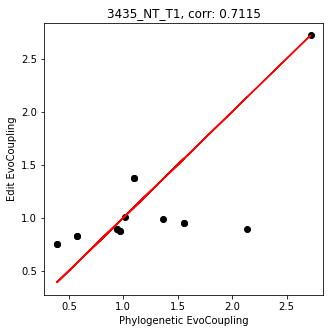

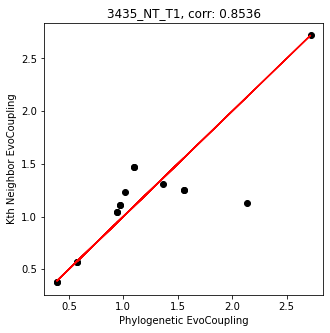

In [18]:
pscores = np.exp(-phylo_zscores_norm / phylo_zscores_norm.abs().max().max())
escores = np.exp(-edit_zscores_norm / edit_zscores_norm.abs().max().max())
kscores = np.exp(-kth_zscores_norm / kth_zscores_norm.abs().max().max())

corr = round(stats.pearsonr(pscores.values.ravel(), escores.values.ravel())[0],4)


h = plt.figure(figsize=(5,5))
plt.scatter(pscores.loc[edit_zscores_norm.index, edit_zscores_norm.columns].values.ravel(), escores.values.ravel(), color='black')
plt.plot(pscores.values.ravel(), pscores.values.ravel(), color='red')
plt.xlabel("Phylogenetic EvoCoupling")
plt.ylabel("Edit EvoCoupling")
plt.title(f"{tumor}, corr: {corr}")

corr = round(stats.pearsonr(pscores.values.ravel(), kscores.values.ravel())[0],4)

h = plt.figure(figsize=(5,5))
plt.scatter(pscores.loc[kscores.index, kscores.columns].values.ravel(), kscores.values.ravel(), color='black')
plt.plot(pscores.values.ravel(), pscores.values.ravel(), color='red')
plt.xlabel("Phylogenetic EvoCoupling")
plt.ylabel("Kth Neighbor EvoCoupling")
plt.title(f"{tumor}, corr: {corr}")

### Evaluate correlations across all tumors -- Figure S5E

All evolutionary couplings were computed with the script in `./scripts/compute_evolutionary_couplings.py`

In [13]:
phylo_vs_edit_corr = []
phylo_vs_knn_corr = []

for tumor in tqdm(adata.obs['Tumor'].unique()):
    
    if 'NT' not in tumor:
        continue
        
    phylo_couplings_fp = f'./data/evolutionary_coupling.{tumor}.preprocessed.txt'
    if not os.path.exists(phylo_couplings_fp):
        continue
        
    phylo_couplings = pd.read_csv(f'./data/evolutionary_coupling.{tumor}.preprocessed.txt', sep='\t', index_col = 0)
    edit_couplings = pd.read_csv(f'./data/evolutionary_coupling.{tumor}.edit.txt', sep='\t', index_col = 0)
    knn_couplings = pd.read_csv(f'./data/evolutionary_coupling.{tumor}.knn_preprocessed.txt', sep='\t', index_col = 0)
    
    pscores = np.exp(-phylo_couplings / phylo_couplings.abs().max().max())
    escores = np.exp(-edit_couplings / edit_couplings.abs().max().max())
    kscores = np.exp(-knn_couplings / knn_couplings.abs().max().max())

    escores = escores.loc[pscores.index, pscores.columns]
    kscores = kscores.loc[pscores.index, pscores.columns]
    
    if len(pscores) < 4:
        continue
    
    edit_corr = round(stats.pearsonr(pscores.values.ravel(), escores.values.ravel())[0],4)
    phylo_vs_edit_corr.append(edit_corr)
    
    knn_corr = round(stats.pearsonr(pscores.values.ravel(), kscores.values.ravel())[0],4)
    phylo_vs_knn_corr.append(knn_corr)


  0%|          | 0/41 [00:00<?, ?it/s]

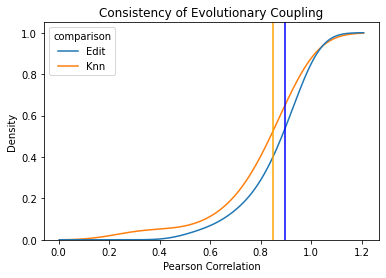

In [16]:
all_correlations = pd.DataFrame([phylo_vs_edit_corr + phylo_vs_knn_corr], index=['correlation']).T
all_correlations['comparison'] = ['Edit']*len(phylo_vs_edit_corr) + ['Knn']*len(phylo_vs_knn_corr)

sns.kdeplot(
    data = all_correlations, x = 'correlation', hue='comparison',
    cumulative=True, common_norm=False, common_grid=True, 
)

plt.axvline(np.median(phylo_vs_edit_corr), color='blue')
plt.axvline(np.median(phylo_vs_knn_corr), color='orange')
plt.title("Consistency of Evolutionary Coupling")
plt.xlabel("Pearson Correlation")
plt.ylabel("Density")
plt.show()


## Analyze Fate Clusters

To do so, we'll use the evolutionary couplings that were computed with `./scripts/compute_evolutionary_couplings.py`

### Hierarchically cluster tumors by Evolutionary Coupling -- Figure S5F

In [20]:
cluster_column = 'leiden_sub'

tumor_z_df_vectors = {}
tumor_z_scores = {}
uniq_labels = adata.obs[cluster_column].astype(int).unique()
tumor_z_df = {}

for tumor in tqdm(adata.obs['Tumor'].unique()):
    
    evolutionary_coupling_fp = f'./data/evolutionary_coupling.{tumor}.preprocessed.txt'
    if not os.path.exists(evolutionary_coupling_fp):
        continue
    
    z_df = pd.read_csv(evolutionary_coupling_fp, sep='\t', index_col = 0)
    z_df.columns = z_df.columns.astype(int)
    z_df.index = z_df.index.astype(int)
    tumor_z_df[tumor] = z_df.copy()
    
    _z_df = pd.DataFrame(np.zeros((len(uniq_labels), len(uniq_labels))), index=uniq_labels, columns = uniq_labels)

    z_scores = pd.DataFrame(np.zeros((len(uniq_labels), len(uniq_labels))), index=uniq_labels, columns = uniq_labels)
    for i in z_df.index:
        for j in z_df.columns:
            _z_df.loc[i, j] = np.exp(-z_df.loc[i ,j])
            z_scores.loc[i, j] = z_df.loc[i, j]
    
    vector = []
    z_vector = []
    labels = []
    inds = _z_df.index
                
    for _i in range(len(uniq_labels)):
        i = inds[_i]
        for _j in range(_i+1, len(uniq_labels)):
            j = inds[_j]
            if i == j:
                vector.append(0)
                z_vector.append(z_scores.loc[i, j])
            elif np.isnan(_z_df.loc[i, j]):
                vector.append(0)
                z_vector.append(0)
            else:
                vector.append(_z_df.loc[i,j])
                z_vector.append(z_scores.loc[i, j])

    cluster_composition = adata.obs.loc[adata.obs['Tumor'] == tumor, cluster_column].value_counts()
    obs_cluster_composition = cluster_composition.loc[[str(c) for c in z_df.index.values]]
    for cluster in uniq_labels:
        if str(cluster) in obs_cluster_composition.index:
            vector.append(obs_cluster_composition.loc[str(cluster)] / obs_cluster_composition.sum())
        else:
            vector.append(0)
    
    tumor_z_df_vectors[tumor] = vector
    tumor_z_scores[tumor] = z_vector

labels = []
z_labels = []
for _i in range(len(uniq_labels)):
    i = inds[_i]
    for _j in range(_i+1, len(uniq_labels)):
        j = inds[_j]
        labels.append(f"({i},{j})")
        z_labels.append(f"({i},{j})")
        
for cluster in uniq_labels:
    labels.append(str(cluster))
    
tumor_z_df_all = pd.DataFrame.from_dict(tumor_z_df_vectors, orient='index', columns = labels)
tumor_z_scores = pd.DataFrame.from_dict(tumor_z_scores, orient='index', columns = z_labels)

  0%|          | 0/41 [00:00<?, ?it/s]

In [21]:
NUM_CELLS_THRESH = 100

tumor_clone_statistics = pd.read_csv("/data/yosef2/users/mattjones/projects/kptc/tumor_statistics.tsv", sep='\t', index_col = 0)

unfiltered = np.intersect1d(tumor_clone_statistics[(tumor_clone_statistics['NumCells'] >= NUM_CELLS_THRESH)].index, tumor_z_df_all.index)

In [27]:
tumor_z_df_nt = tumor_z_df_all.loc[unfiltered]

tmat_z = tumor_z_df_nt \
    .subtract(tumor_z_df_nt.mean(axis=1), axis=0) \
    .divide(tumor_z_df_nt.std(axis=1), axis=0)

tmat_z = np.nan_to_num(tmat_z)

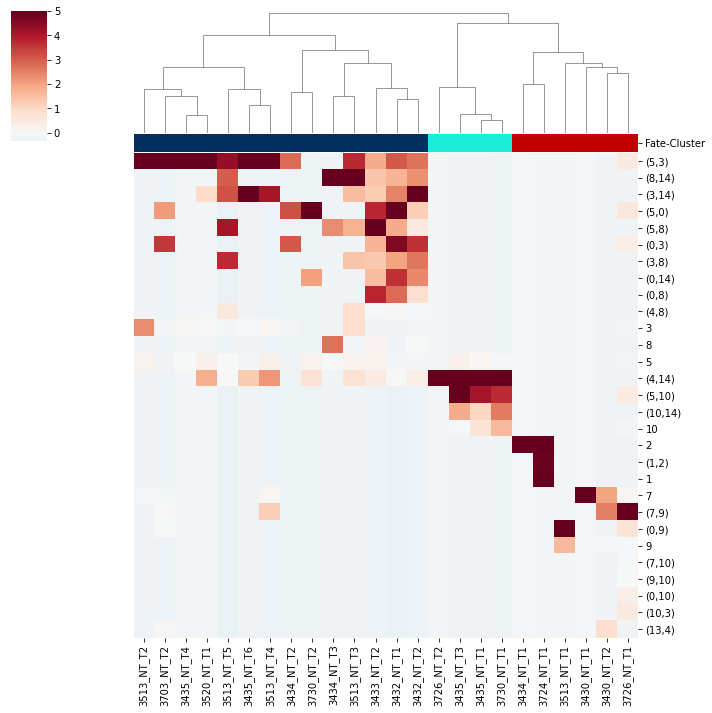

In [34]:

fate_to_color = {1: "#022e60",
                2: "#1cecdc",
                3: "#c30000",
                4: "#9bb7d4",
                5: "#efbc74"}

tumor_hierarchy = hierarchy.linkage(
    distance.pdist(tmat_z, metric='euclidean'), method='ward')

hierarchical_clusters = hierarchy.fcluster(tumor_hierarchy, t=3, criterion="maxclust")

tumor_to_cluster = {}
for i, tumor in zip(range(len(tumor_z_df_nt.index)), tumor_z_df_nt.index):
    tumor_to_cluster[tumor] = hierarchical_clusters[i]

colors = pd.DataFrame.from_dict({tumor: fate_to_color[tumor_to_cluster[tumor]] for tumor in tumor_z_df_nt.index}, orient='index', columns = ['Fate-Cluster'])

# these rows were hand selected to best represent the separation 
row_order = ['(5,3)', '(8,14)', '(3,14)', '(5,0)', '(5,8)', '(0,3)', '(3,8)', '(0,14)', '(0,8)', '(4,8)', '3', '8', '5',
            '(4,14)', '(5,10)', '(10,14)', '10',
            '2', '(1,2)', '1', '7', '(7,9)', '(0,9)', '9', '(7,10)', '(9,10)', '(0,10)', '(10,3)','(13,4)']

result = sns.clustermap(pd.DataFrame(tmat_z, index = tumor_z_df_nt.index, columns = tumor_z_df_nt.columns).T.loc[row_order], center = 0.0,
               cmap = 'RdBu_r', vmax=5, col_linkage=tumor_hierarchy, method='ward', row_cluster=False, col_colors=colors['Fate-Cluster'], figsize=(10, 10), annot_kws={'font_size': 3})


### Evaluate leiden cluster proportion by fate cluster - Figure S5G

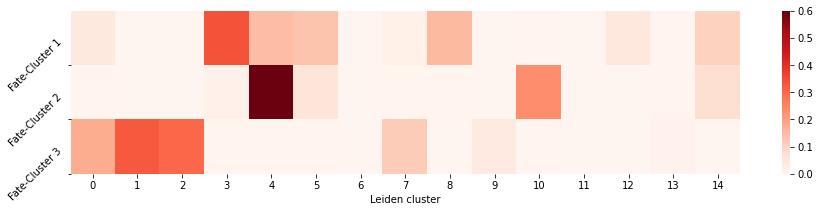

In [49]:
leiden_assignments = adata.obs[['Tumor', 'leiden_sub']].copy()
leiden_assignments['fate_cluster'] = leiden_assignments['Tumor'].map(tumor_to_cluster)

fate_cluster_props = leiden_assignments.groupby(by = ['fate_cluster', 'leiden_sub']).size() / leiden_assignments.groupby(by = 'fate_cluster').size()
fate_cluster_props = fate_cluster_props.unstack()

h = plt.figure(figsize=(15, 3))
sns.heatmap(fate_cluster_props, cmap='Reds', vmin=0, vmax=0.6)
plt.yticks([1, 2, 3], ['Fate-Cluster 1', 'Fate-Cluster 2', 'Fate-Cluster 3'], rotation=45)
plt.ylabel(None)
plt.xlabel("Leiden cluster")
plt.show()

### Perform Dimensionality Reduction Anlaysis - Figures 5E and S5H,I

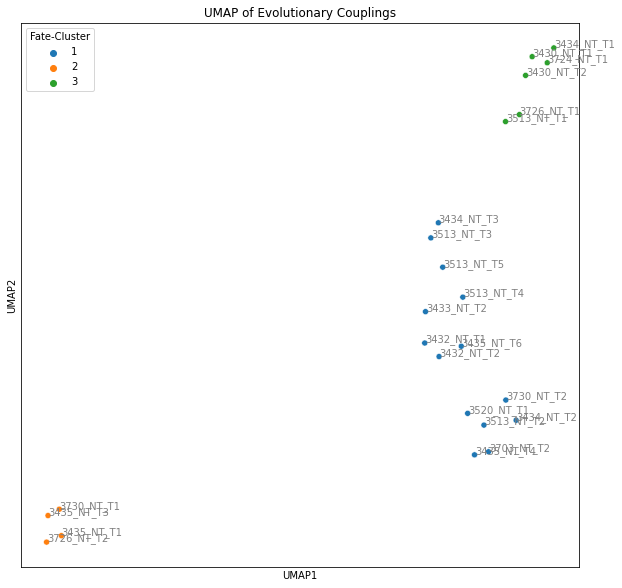

In [70]:
import umap

seed = 2

reducer = umap.UMAP(n_neighbors=3, min_dist=0.2,
                    random_state=np.random.RandomState(seed), metric='euclidean')
embedding = reducer.fit_transform(tmat_z)

embedding_df = pd.DataFrame(embedding, index=tumor_z_df_nt.index.values, columns = ['UMAP1', 'UMAP2'])
embedding_df['Fate-Cluster'] = hierarchical_clusters
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=embedding_df, x='UMAP1', y='UMAP2', hue='Fate-Cluster', palette='tab10')
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
for i, label in zip(range(len(labs)), labs):
    plt.annotate(label, (embedding[i,0]+0.01, embedding[i,1]+0.01), color='grey')
plt.yticks([])
plt.xticks([])
plt.title("UMAP of Evolutionary Couplings")
plt.show()

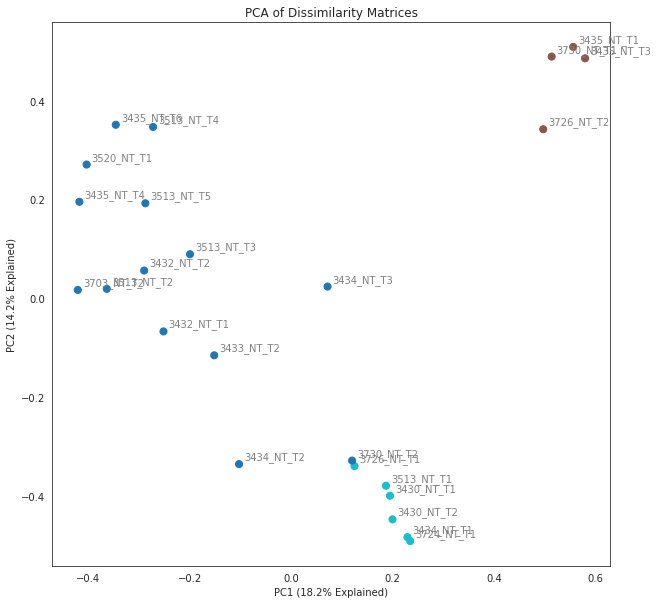

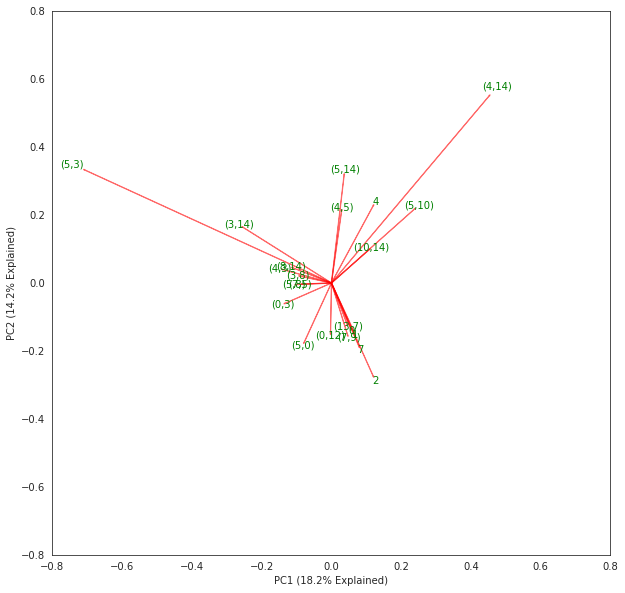

In [74]:
pca = PCA()
tmat_transformed = pca.fit_transform(tmat_z)
var_explained = pca.explained_variance_ratio_

d1, d2 = 0,1

sns.set_style("white")
tumors = tumor_z_df_nt.index

x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]
sizes = dict(zip(tumor_z_df_nt.index.values, x))
ss = dict(zip(tumor_z_df_nt.index.values, y))
labs = tumor_z_df_nt.index.values

scalex = 1.0/(x.max() - x.min())
scaley = 1.0/(y.max() - y.min())

h = plt.figure(figsize = (10, 10))
ax = plt.scatter(x*scalex, y*scaley, c=hierarchical_clusters[:], s=50, cmap = 'tab10')
plt.title("PCA of Dissimilarity Matrices")

for i in labs:
    plt.annotate(i, (sizes[i]*scalex+0.01, ss[i]*scaley+0.01), color='grey')

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))
plt.show()


h = plt.figure(figsize = (10, 10))
coeff = np.transpose(pca.components_)

iis = np.argsort(np.abs(coeff[:, d1]))[::-1][:15]
iis = np.unique(np.concatenate((iis, np.argsort(np.abs(coeff[:, d2]))[::-1][:15])))
for i in iis:
    plt.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = 'r',alpha = 0.5)
    plt.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))

plt.show()


## Phylotime analysis

Below, we compute the phylotimes for each cell in each tumor. Because there could be some minor stochasticity in the clustering assignments of tumors based on Evolutionary Coupling, we define the fate clusters identified in our manuscript below.

In [29]:
def post_process_phylotimes(phylotimes, adata):
    
    phylotimes = phylotimes.dropna().copy()

    # perform smoothing
    phylotimes = phylotimes.replace([np.inf, -np.inf], np.nan).dropna()
    phylotimes = tree_utilities.perform_smoothing(phylotimes, adata, K = 20)
    phylotimes = phylotimes.replace([np.inf, -np.inf], np.nan).dropna()

    t1 = phylotimes.index.values
    bg = np.setdiff1d(adata.obs_names, t1)

    umap = pd.DataFrame(adata.obsm["X_umap"], index = adata.obs_names, columns = ['D1', 'D2'])
    _mi, _ma = phylotimes.min(), phylotimes.max()
    phylotimes = phylotimes.apply(lambda x: (x.distance-_mi) / (_ma - _mi), axis=1)

    phylotimes.dropna(inplace=True)

    t1 = phylotimes.index.values
    bg = np.setdiff1d(adata.obs_names, t1)

    vmin = np.percentile(phylotimes.values, 5)
    vmax = np.percentile(phylotimes.values, 90)

    t1 = phylotimes.index.values
    bg = np.setdiff1d(adata.obs_names, t1)

    umap = pd.DataFrame(adata.obsm["X_umap"], index = adata.obs_names, columns = ['D1', 'D2'])

    _mi, _ma = phylotimes.min(), phylotimes.max()
    phylotimes = phylotimes.apply(lambda x: (x.distance-_mi) / (_ma - _mi), axis=1)

    phylotimes.dropna(inplace=True)

    t1 = phylotimes.index.values
    bg = np.setdiff1d(adata.obs_names, t1)

    vmin = np.percentile(phylotimes.values, 5)
    vmax = np.percentile(phylotimes.values, 95)

    fig, ax = plt.subplots(figsize = (6,6))
    plt.scatter(umap.loc[bg, 'D1'], umap.loc[bg, 'D2'], c='lightgray', s=0.1)
    plt.scatter(umap.loc[t1, 'D1'], umap.loc[t1, 'D2'], c=phylotimes_bl.loc[t1].values, s=2, cmap = 'YlOrRd_r', vmin=vmin, vmax=vmax)

    plt.xlabel('UMAP 1')
    plt.ylabel("UMAP 2")
    plt.colorbar()
    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()
    
    return phylotimes

  0%|          | 0/13 [00:00<?, ?it/s]

/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
scripts/tree_utilities.py:462: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  connectivities = neighbors['connectivities'][index,:]


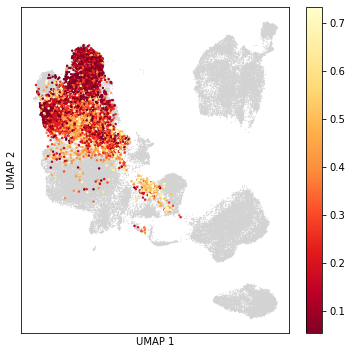

/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
scripts/tree_utilities.py:462: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  connectivities = neighbors['connectivities'][index,:]


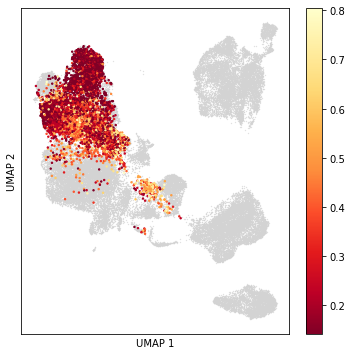

In [33]:
fate_cluster_to_tumors = {
    'fate_cluster1': ['3513_NT_T2', '3703_NT_T2', '3435_NT_T4', '3520_NT_T1',
                      '3513_NT_T5', '3435_NT_T6', '3513_NT_T4', '3730_NT_T2',
                      '3434_NT_T3', '3513_NT_T3', '3433_NT_T2', '3432_NT_T1',
                      '3432_NT_T2'],
    'fate_cluster2': ['3726_NT_T2', '3730_NT_T1', '3435_NT_T1', '3435_NT_T3'],
    'fate_cluster3': ['3434_NT_T1', '3724_NT_T1', '3513_NT_T1', '3430_NT_T1',
                      '3430_NT_T2', '3726_NT_T1'],
}


cluster_column = 'leiden_sub'

tumors = fate_cluster_to_tumors['fate_cluster1']

at2 = '4'

phylotimes_capped = pd.DataFrame(columns=['distance'])
phylotimes_bl = pd.DataFrame(columns = ['distance'])
for tumor in tqdm(tumors):
    
    graph = tree_utilities.prepare_tumor_tree(tumor, adata,
                                              '/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/trees',
                                              column=cluster_column, FILTER_PROP=0.025, keep_branch_lengths = False)
        
    leaves = [n for n in graph if graph.out_degree(n) == 0]
    at2_cells = np.intersect1d(adata.obs[adata.obs[cluster_column] == at2].index, leaves)
        
    if len(at2_cells) <= 1:
        continue
    
    # compute phylotimes with 0-1 branch lenghts
    capped_distances = tree_utilities.compute_fitch_distance(graph, adata.obs[cluster_column], ground_state=at2)
    
    # compute branch-length distances
    graph = tree_utilities.prepare_tumor_tree(tumor, adata,
                                              '/data/yosef2/users/mattjones/projects/kptc/KPTracer-Data/trees',
                                              column=cluster_column, FILTER_PROP=0.025, keep_branch_lengths = True)
    
    bl_distances = tree_utilities.compute_fitch_distance(graph, adata.obs[cluster_column], ground_state=at2)
    
    capped_distances.dropna(inplace=True)
    bl_distances.dropna(inplace=True)

    phylotimes_capped = pd.concat([phylotimes_capped, capped_distances])
    phylotimes_bl = pd.concat([phylotimes_bl, bl_distances])

    
phylotimes_capped = post_process_phylotimes(phylotimes_capped, adata)
phylotimes_bl = post_process_phylotimes(phylotimes_bl, adata)

### Compare phylotimes with different dissimilarity metrics - Figure S5J,K

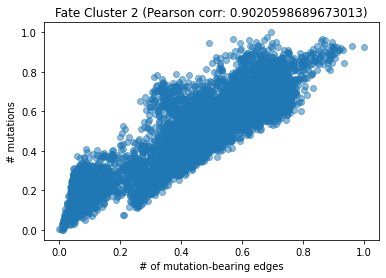

In [34]:
corr = stats.pearsonr(phylotimes_capped.loc[phylotimes_bl.index, 'distance'], phylotimes_bl['distance'])[0]

plt.scatter(phylotimes_capped.loc[phylotimes_bl.index, 'distance'], phylotimes_bl['distance'], alpha=0.5)
plt.xlabel("# of mutation-bearing edges")
plt.ylabel("# mutations")
plt.title(f'Fate Cluster 2 (Pearson corr: {corr})')
plt.show()

### Running tradeseq

Tradeseq was used to perform DE tests for each gene in each fate cluster across phylotime. The script located in `./scripts/run_tradeseq.r` contains the code used for this analysis.